In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from joblib import Parallel, delayed
from glob import glob

from astropy.io import fits
from astropy.wcs import WCS

In [2]:
tess_filename = "data/tess/20_3_3/tess2020019135923-s0020-3-3-0165-s_ffic.fits"
tess_hdu = fits.open(tess_filename)
tess_header = tess_hdu[1].header
tess_wcs = WCS(tess_hdu[1].header)
tess_data = tess_hdu[1].data.astype(float)

t_y, t_x = np.shape(tess_data)
ty, tx = np.mgrid[:t_y, :t_x]
ty = ty.ravel().astype(int)
tx = tx.ravel().astype(int)

skycell_path = "data/tess_comb_skycells_conv/"

mask_files = glob(skycell_path + "*stk.rizy.conv.mask.fits")
ps1_files = glob(skycell_path + "*.stk.rizy.conv.fits")
ps1_files.sort()

registrations = glob("data/skycell_pixel_mapping/sector020/*.gz")
registrations.sort()
master_registration = registrations[1]
registrations = registrations[2:]

reg_sc = np.array([s.split("skycell.")[-1].split("_")[0] for s in registrations])
ps1_sc = np.array([s.split("skycell.")[-1].split(".stk")[0] for s in ps1_files])

# ps1_assignment = np.load('test_assignment.npy').astype(int)

Set MJD-END to 58867.605545 from DATE-END'. [astropy.wcs.wcs]


In [4]:
tess_header

XTENSION= 'IMAGE   '           / marks the beginning of a new HDU               
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / NAXIS                                          
NAXIS1  =                 2136 / length of first array dimension                
NAXIS2  =                 2078 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'CAMERA.CCD 3.3 cal' / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
TELESCOP= 'TESS    '           / telescope                                      
INSTRUME= 'TESS Photometer' 

In [3]:
tess_img_ps1_skycell = fits.open(master_registration)[1].data

In [4]:
tess_img_ps1_skycell

array([[ 342,  342,  342, ..., 1452, 1452, 1452],
       [ 342,  342,  342, ..., 1452, 1452, 1452],
       [ 342,  342,  342, ..., 1452, 1452, 1452],
       ...,
       [  41,   41,   41, ..., 1517, 1517, 1517],
       [  41,   41,   41, ..., 1517, 1517, 1517],
       [  41,   41,   41, ..., 1517, 1517, 1517]],
      shape=(2078, 2136), dtype='>i4')

In [5]:
skycell_csv = "./data/SkyCells/skycell_coordinates.csv"
skycell_df = pd.read_csv(skycell_csv)

In [ ]:
hdul = fits.open(tess_filename)
super_data = hdul[1].data
data_shape = np.shape(super_data)
super_wcs = WCS(hdul[1].header)
im1_poly = super_wcs.calc_footprint()
hdul.close()

ra_centre, dec_centre = super_wcs.all_pix2world(data_shape[0] // 2, data_shape[1] // 2, 0)

Set MJD-END to 58867.605545 from DATE-END'. [astropy.wcs.wcs]


In [ ]:
def angular_distance(ra1, dec1, ra2, dec2):
    """
    Vectorized great-circle distance using haversine formula.
    All inputs assumed in degrees.
    """
    ra1_rad, dec1_rad = np.radians(ra1), np.radians(dec1)
    ra2_rad, dec2_rad = np.radians(ra2), np.radians(dec2)

    delta_ra = ra2_rad - ra1_rad
    delta_dec = dec2_rad - dec1_rad

    a = np.sin(delta_dec / 2.0) ** 2 + np.cos(dec1_rad) * np.cos(dec2_rad) * np.sin(delta_ra / 2.0) ** 2
    return np.degrees(2 * np.arcsin(np.sqrt(a)))


def max_radius(ra_centre, dec_centre, ra_corners, dec_corners):
    """
    Compute max angular separation from center to any corner.
    """
    ra_corners = np.asarray(ra_corners)
    dec_corners = np.asarray(dec_corners)
    dists = angular_distance(ra_centre, dec_centre, ra_corners, dec_corners)
    return np.max(dists)


# def name_skycells(skycell_df):
#     """
#     Name and find appropriate skycells for the TESS image
#     """

ra_corners = im1_poly[:, 0]
dec_corners = im1_poly[:, 1]

radius_var = max_radius(ra_centre, dec_centre, ra_corners, dec_corners) + np.sqrt(2) * 0.4

radius = angular_distance(ra_centre, dec_centre, skycell_df["RA"].to_numpy(), skycell_df["DEC"].to_numpy())

mask = radius < radius_var

skycells_list = skycell_df[mask].Name.to_numpy()

In [8]:
skycells_list

array(['skycell.2521.090', 'skycell.2521.091', 'skycell.2521.092', ...,
       'skycell.2640.048', 'skycell.2640.049', 'skycell.2640.059'],
      shape=(1909,), dtype=object)

In [9]:
np.unique(tess_img_ps1_skycell).shape

(994,)

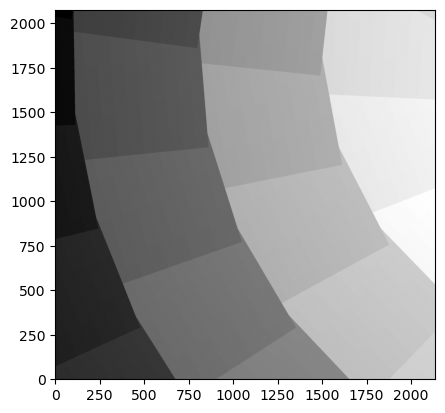

In [10]:
plt.imshow(tess_img_ps1_skycell, origin="lower", cmap="gray")

In [11]:
skycells_tess_pixels = skycells_list[tess_img_ps1_skycell]

In [12]:
# Offset RA and DEC
offset_ra = 1 / 60 / 60  # in degrees
offset_dec = 1 / 60 / 60  # in degrees

In [13]:
len(registrations)

2161

In [53]:
for i, reg in enumerate(registrations):
    if skycells_tess_pixels[0, 0] in reg:
        print(reg)
        break

data/skycell_pixel_mapping/sector020/TESS_s0020_11_skycell.2559.028_00309.fits.gz


In [54]:
# i = 105
reg = registrations[i]
ps1_ind = np.where(reg_sc[i] == ps1_sc)[0]
ps1_data = fits.open(reg)[1]
ps1_assignment = ps1_data.data
ps1_wcs = WCS(ps1_data.header)
pind = ps1_assignment.ravel()
sort_ind = np.argsort(pind)
ps1_ind

array([312])

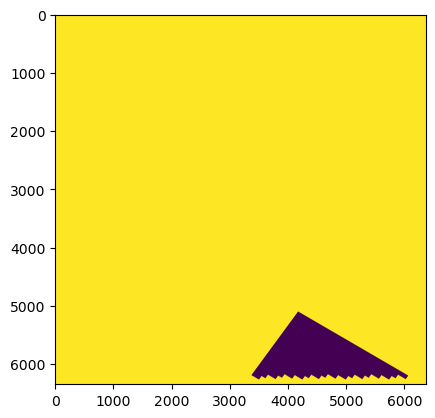

In [16]:
plt.imshow(ps1_assignment)

In [17]:
np.unique(ps1_assignment)

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
       65535], dtype=uint16)

In [19]:
ps1_data.header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6365                                                  
NAXIS2  =                 6350                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
NAME    = 'skycell.2559.028'                                                    
CRVAL1  =    229.0909118652344                                                  
CRVAL2  =                 70.0                                                  
CRPIX1  =             -17416.5                                                  
CRPIX2  =              17850.0                                                  
CDELT1  =        6.9444446E-

In [18]:
ps1_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 229.0909118652344 70.0 
CRPIX : -17416.5 17850.0 
PC1_1 PC1_2  : -1.0 0.0 
PC2_1 PC2_2  : -0.0 1.0 
CDELT : 6.9444446e-05 6.9444446e-05 
NAXIS : 6365  6350

In [32]:
ps1_wcs.pixel_scale_matrix

array([[-6.9444446e-05,  0.0000000e+00],
       [ 0.0000000e+00,  6.9444446e-05]])

In [36]:
offset_ra / ps1_wcs.pixel_scale_matrix[0, 0]

np.float64(-3.999999910400002)

In [37]:
offset_dec / ps1_wcs.pixel_scale_matrix[1, 1]

np.float64(3.999999910400002)

In [39]:
new_center = ps1_wcs.pixel_to_world_values([[ps1_wcs.array_shape[0] // 2, ps1_wcs.array_shape[1] // 2]])[0] + np.array([offset_ra, offset_dec])

In [41]:
new_center

array([225.11116593,  68.93548281])

In [43]:
ps1_wcs.world_to_pixel_values([new_center])[0] - np.array([ps1_wcs.array_shape[0] // 2, ps1_wcs.array_shape[1] // 2])

array([-1.69687021,  3.90089638])

In [ ]:
ps1_data

In [44]:
y_pix, x_pix = tess_data.shape
scene = np.zeros((y_pix, x_pix), dtype=float)
scene_num = np.zeros((y_pix, x_pix), dtype=int)
scene_mask = np.zeros((y_pix, x_pix), dtype=int)

In [63]:
ps1_assignment_x = fits.open(reg)[1].data
ps1_assignment_x = ps1_assignment_x.astype(int)
ps1_assignment_x[ps1_assignment_x == 65535] = -1
ps1_assignment_y = fits.open(reg)[2].data
ps1_assignment_y = ps1_assignment_y.astype(int)
ps1_assignment_y[ps1_assignment_y == 65535] = 0
ps1_assignment = ps1_assignment_x + ps1_assignment_y * x_pix

In [46]:
ps1_assignment

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], shape=(6350, 6365))

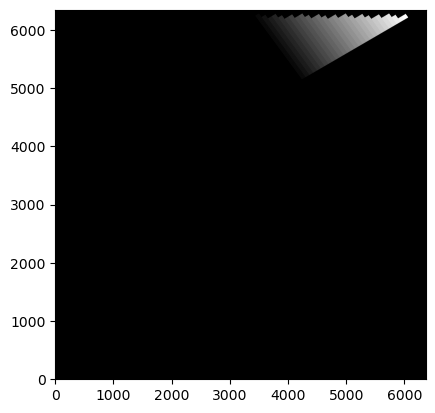

In [47]:
plt.imshow(ps1_assignment, origin="lower", cmap="gray")

In [48]:
# shift ps1_assignment 10 pixels to the right and 5 pixels up
shifted_assignment = np.roll(ps1_assignment, shift=(10, -5), axis=(0, 1))

In [55]:
ps1_filename = ps1_files[ps1_ind[0]]
ps1_mask_filename = ps1_filename.replace(".fits", ".mask.fits")
ps1_data = fits.open(ps1_filename)[0].data
ps1_mask = fits.open(ps1_mask_filename)[0].data

In [56]:
pind = ps1_assignment.ravel()
sort_ind = np.argsort(pind)

ps1_rav = ps1_data[500:-500, 500:-500].ravel()[sort_ind]
ps1_mask_rav = ps1_mask[500:-500, 500:-500].ravel()[sort_ind]

In [66]:
pind

array([65535, 65535, 65535, ..., 65535, 65535, 65535],
      shape=(40417750,), dtype=uint16)

In [57]:
tess_pixels = np.unique(pind[np.isfinite(pind)]).astype(int)
tess_pixels = tess_pixels[tess_pixels >= 0]

breaks = np.where(np.diff(pind[sort_ind]) > 0)[0] + 1
breaks = np.append(breaks, len(ps1_rav))

In [67]:
tess_pixels = tess_pixels[:-1]

In [ ]:
sums = np.zeros(len(breaks) - 1, dtype=float)
isums = np.zeros(len(breaks) - 1, dtype=int)
msums = np.zeros(len(breaks) - 1, dtype=int)
for i in range(len(breaks) - 1):
    sums[i] = np.sum(ps1_rav[breaks[i] : breaks[i + 1]])
    isums[i] = breaks[i + 1] - breaks[i]
    msums[i] = np.sum(ps1_mask_rav[breaks[i] : breaks[i + 1]] != 0)

scene[ty[tess_pixels], tx[tess_pixels]] += sums
scene_num[ty[tess_pixels], tx[tess_pixels]] += isums
scene_mask[ty[tess_pixels], tx[tess_pixels]] += msums

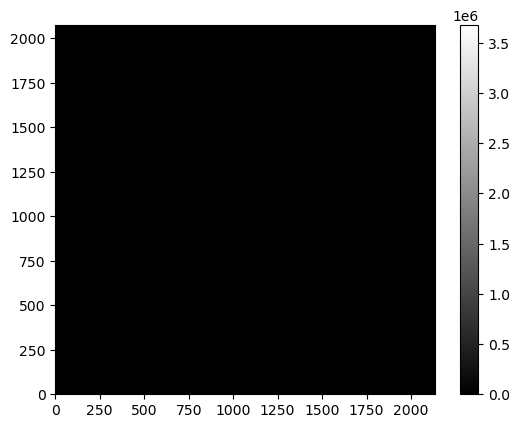

In [ ]:
plt.imshow(scene, cmap="gray", origin="lower")
# plt.xlim(140, 250)
# plt.ylim(220, 340)
plt.colorbar()

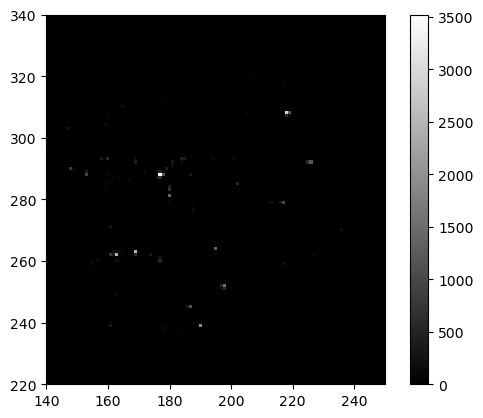

In [188]:
plt.imshow(scene_mask, cmap="gray", origin="lower")
plt.xlim(140, 250)
plt.ylim(220, 340)
plt.colorbar()

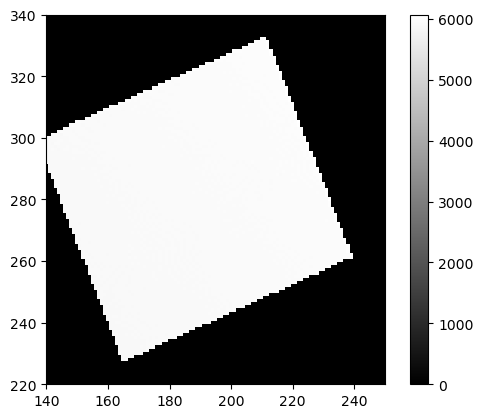

In [181]:
plt.imshow(scene_num, cmap="gray", origin="lower")
plt.xlim(140, 250)
plt.ylim(220, 340)
plt.colorbar()

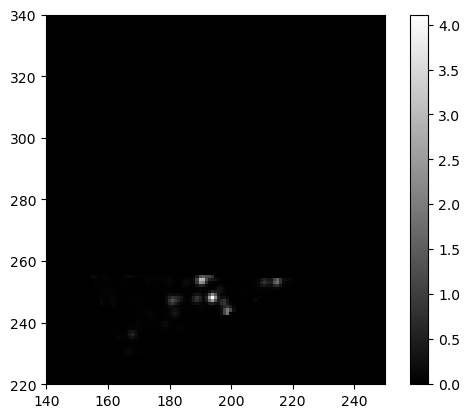

In [103]:
plt.imshow(scene, cmap="gray", origin="lower")
plt.xlim(140, 250)
plt.ylim(220, 340)
plt.colorbar()

In [102]:
for i, p in enumerate(tess_pixels):
    x = p % x_pix
    y = p // x_pix
    scene[y, x] = np.mean(ps1_data[np.where(ps1_assignment == tess_pixels[i])])
    if i > 1000:
        break

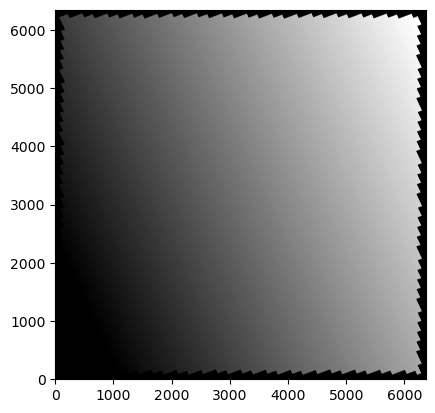

In [75]:
plt.imshow(ps1_assignment, cmap="gray", origin="lower", vmin=509363, vmax=709363)

In [ ]:
plt.plot()

In [19]:
sums

array([ 321.27262517,  332.81622273,  355.04414975, ...,  765.55413224,
       3906.5019555 ,    0.        ], shape=(1591,))

In [52]:
def parallel_downsample(registration, ps1_files, reg_sc, ps1_sc, scene, scene_num):
    reg = registration
    ps1_ind = np.where(reg_sc == ps1_sc)[0]
    if len(ps1_ind) > 0:
        try:
            y_pix, x_pix = scene.shape
            ps1_assignment_x = fits.open(reg)[1].data
            ps1_assignment_x = ps1_assignment_x.astype(int)
            ps1_assignment_x[ps1_assignment_x == 65535] = -1
            ps1_assignment_y = fits.open(reg)[2].data
            ps1_assignment_y = ps1_assignment_y.astype(int)
            ps1_assignment_y[ps1_assignment_y == 65535] = 0
            ps1_assignment = ps1_assignment_x + ps1_assignment_y * x_pix

            pind = ps1_assignment.ravel()
            sort_ind = np.argsort(pind)

            ps1_data = fits.open(ps1_files[ps1_ind[0]])[0].data
            ps1_rav = ps1_data.ravel()[sort_ind]
            tess_pixels = np.unique(pind[np.isfinite(pind)]).astype(int)
            tess_pixels = tess_pixels[tess_pixels >= 0]

            breaks = np.where(np.diff(pind[sort_ind]) > 0)[0]
            breaks = np.append(breaks, len(ps1_rav))

            sums = np.zeros(len(breaks) - 1, dtype=float)
            isums = np.zeros(len(breaks) - 1, dtype=int)
            for i in range(len(breaks) - 1):
                sums[i] = np.sum(ps1_rav[breaks[i] : breaks[i + 1]])
                isums[i] = breaks[i + 1] - breaks[i]
                # msums += [np.bitwise_or.reduce(mask_rav[breaks[i]:breaks[i+1]])]

            scene[ty[tess_pixels], tx[tess_pixels]] += sums
            scene_num[ty[tess_pixels], tx[tess_pixels]] += isums

        except Exception as e:
            print(f"Error processing {reg_sc[ps1_ind[0]]} with {ps1_files[ps1_ind[0]]}: {e}")
    return scene

In [ ]:
y_pix, x_pix = tess_data.shape
scene = np.zeros((y_pix, x_pix), dtype=float)
scene_num = np.zeros((y_pix, x_pix), dtype=int)

for i in range(100, 105):
    parallel_downsample(registrations[i], ps1_files, reg_sc[i], ps1_sc, scene, scene_num)
    print(f"done {i} of {len(registrations)}")

(200.0, 250.0)

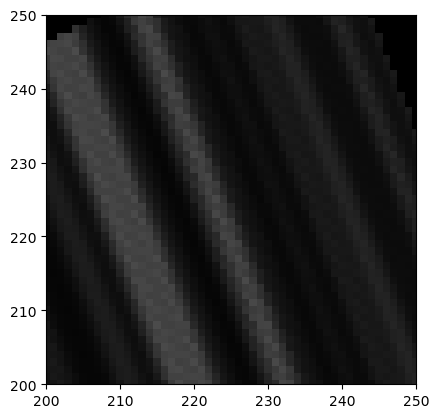

In [63]:
plt.imshow(scene, cmap="gray", origin="lower")
plt.xlim(200, 250)
plt.ylim(200, 250)

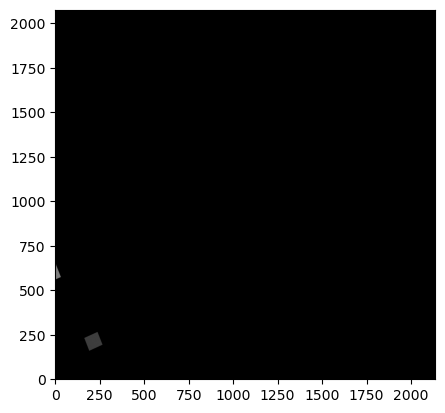

In [62]:
plt.imshow(scene_num, cmap="gray", origin="lower")

In [121]:
def run_parallel_downsample(registrations, reg_sc_split, tess_data_shape, ps1_files, ps1_sc):
    scene = np.zeros(tess_data_shape)
    for i, reg_sc in enumerate(reg_sc_split):
        scene = parallel_downsample(registration=registrations[i], ps1_files=ps1_files, reg_sc=reg_sc, ps1_sc=ps1_sc, scene=scene)
    return scene

In [ ]:
n = 30
reg_sc_split = np.split(reg_sc, n)
registrations_split = np.split(np.array(registrations), n)
inds = np.arange(len(reg_sc_split))
tess_data_shape = tess_data.shape

scenes = Parallel(n_jobs=n)(delayed(run_parallel_downsample)(registrations=registrations_split[i], reg_sc_split=reg_sc_split[i], tess_data_shape=tess_data_shape, ps1_files=ps1_files, ps1_sc=ps1_sc) for i in inds)

In [ ]:
tess_syndiff = np.load("data/tess_downsampled.npy")

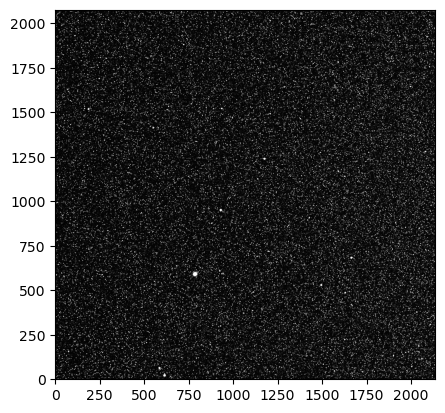

In [3]:
plt.imshow(tess_syndiff[0] / tess_syndiff[1], cmap="gray", origin="lower", vmin=0, vmax=1)
# plt.ylim(2000, 2100)
# plt.xlim(0, 200)

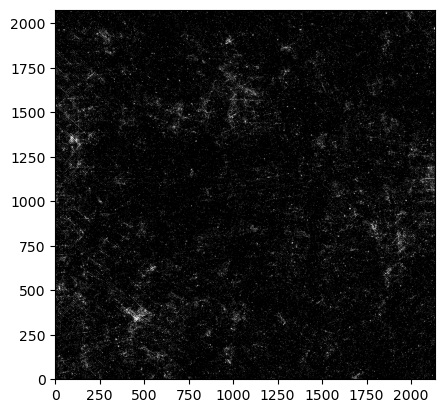

In [4]:
plt.imshow(tess_syndiff[2], cmap="gray", origin="lower", vmin=0, vmax=0.00001)
# plt.ylim(2000, 2100)
# plt.xlim(0, 200)

In [43]:
mask_ratio = tess_syndiff[2] / tess_syndiff[1]

In [ ]:
from astropy.modeling import models


def _make_psf(psf_std):
    size = 3
    y, x = np.mgrid[:size, :size]
    x = x - size / 2
    y = y - size / 2
    psfg = models.Gaussian2D(x_stddev=psf_std, y_stddev=psf_std)
    psfg = psfg(x, y)
    psfg /= np.nansum(psfg)
    return psfg


from scipy.signal import fftconvolve

mask_ratio_conv = fftconvolve(mask_ratio, _make_psf(0.8), mode="same")

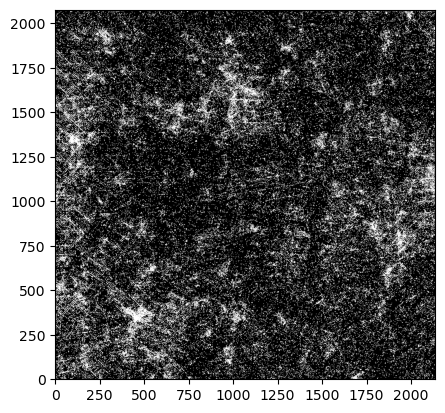

In [7]:
plt.imshow(mask_ratio_conv, cmap="gray", origin="lower", vmin=0, vmax=0.00001)
# plt.ylim(2000, 2100)
# plt.xlim(0, 200)

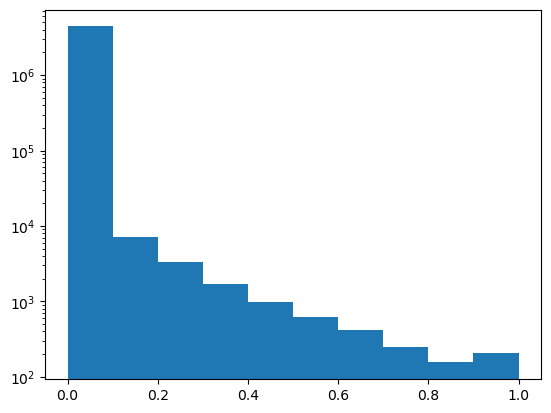

In [ ]:
plt.hist(mask_ratio.flatten())
plt.yscale("log")
plt.show()

In [46]:
np.sum(mask_ratio > 0) / len(mask_ratio.flatten())

np.float64(0.04163535054233219)

In [47]:
np.sum(mask_ratio_conv > 0.001) / len(mask_ratio.flatten())

np.float64(0.059746884608868366)

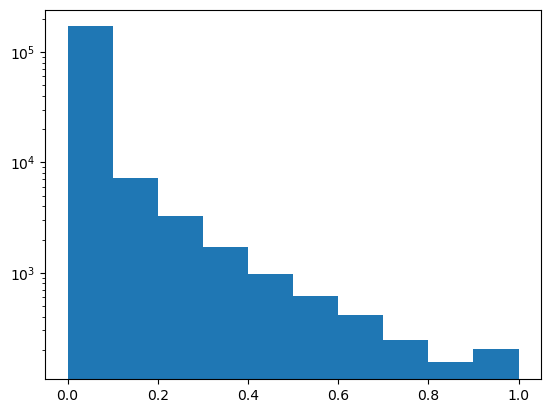

In [11]:
plt.hist(mask_ratio[mask_ratio > 0].flatten())
plt.yscale("log")
plt.show()

In [48]:
mask = mask_ratio_conv > 0.0000001

In [49]:
np.sum(mask) / len(mask_ratio.flatten())

np.float64(0.21143160197971977)

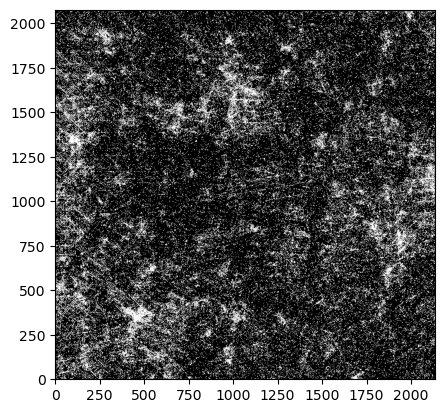

In [14]:
plt.imshow(mask, cmap="gray", origin="lower", vmin=0, vmax=1)

In [ ]:
data = tess_syndiff[0] / tess_syndiff[1]

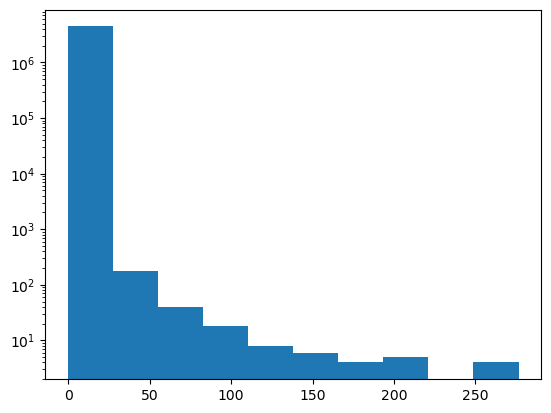

In [16]:
plt.hist(data.flatten())
plt.yscale("log")
plt.show()

In [54]:
data_median = np.nanmedian(data)
data_90_percentile = np.nanpercentile(data, 90)
# data_10_percentile = np.nanpercentile(data, 10)
data_10_percentile = -10000
data_std = np.nanstd(data[np.logical_and(data > data_10_percentile, data < data_90_percentile)])
data_b = data[np.logical_and(data > data_10_percentile, data < data_90_percentile)]

In [55]:
data_std

np.float64(0.04329825809820137)

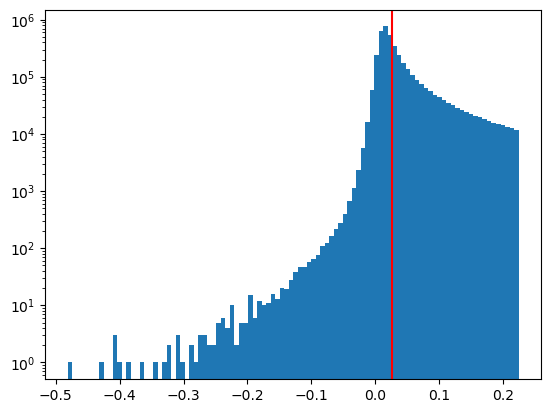

In [56]:
plt.hist(data_b.flatten(), bins=100)
plt.axvline(data_median, color="red", label="median")
plt.yscale("log")
plt.show()

In [57]:
below_zero = data_b[data_b < 0]
dist = np.concatenate([below_zero, below_zero * -1])
np.std(dist)

np.float64(0.014957208526026965)

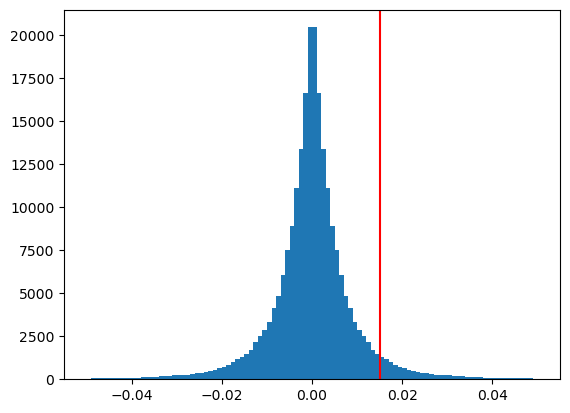

In [58]:
plt.hist(dist.flatten(), range=(-0.05, 0.05), bins=100)
plt.axvline(np.std(dist), color="red", label="zero")

In [59]:
noise_level = np.std(dist)

In [60]:
mask[-30:, :] = True
mask[:, :44] = True
mask[:, -44:] = True

In [57]:
primary_hdu = fits.PrimaryHDU()
hdu1 = fits.ImageHDU(data=tess_syndiff[0] / tess_syndiff[1], header=tess_header, name="FLUX")
hdu2 = fits.ImageHDU(data=tess_syndiff[1], header=tess_header, name="COUNT")
hdu3 = fits.ImageHDU(data=tess_syndiff[2], header=tess_header, name="MASK")

hdu_list = [primary_hdu, hdu1, hdu2, hdu3]

# Write to FITS file
output_filename = "data/syndiff_ffi_second.fits"
fits.HDUList(hdu_list).writeto(output_filename, overwrite=True)

In [ ]:
primary_hdu = fits.PrimaryHDU()
hdu1 = fits.ImageHDU(data=tess_syndiff[0] / tess_syndiff[1], header=tess_header, name="FLUX")
# hdu2 = fits.ImageHDU(data=tess_syndiff[1], header=tess_header, name="COUNT")
# hdu3 = fits.ImageHDU(data=tess_syndiff[2], header=tess_header, name="MASK")

hdu_list = [primary_hdu, hdu1]

# Write to FITS file
output_filename = "data/syndiff_ffi_second_template.fits"
fits.HDUList(hdu_list).writeto(output_filename, overwrite=True)

In [11]:
tess_ffi = fits.open("data/difference_image/tess2019358235923-s0020-3-3-0165-s_ffic.fits")
primary_hdu = fits.PrimaryHDU()
hdu1 = fits.ImageHDU(data=tess_ffi[1].data, header=tess_ffi[1].header, name="FLUX")
hdu_list = [primary_hdu, hdu1]

# Write to FITS file
output_filename = "data/tess_image.fits"
fits.HDUList(hdu_list).writeto(output_filename, overwrite=True)

In [ ]:
# copy tess_header and add a new keyword called 'SYNDIFF' and set it to True
syndiff_header = tess_header.copy()
syndiff_header["SYNDIFF"] = True
# remove CHECKSUM
if "CHECKSUM" in syndiff_header:
    syndiff_header.remove("CHECKSUM")

In [40]:
keys_to_copy = ["TELESCOP", "INSTRUME", "CAMERA", "CCD"]
syndiff_header = fits.Header()
for key in keys_to_copy:
    if key in tess_header:
        syndiff_header.set(key, tess_header[key], tess_header.comments[key])
syndiff_header.set("MJD-OBS", "55197.00000", "TSTART of PS1")

syndiff_header.set("DATE-OBS", "2010-01-01T00:00:00.000", "TSTART of PS1")
syndiff_header.set("DATE-END", "2015-01-01T00:00:00.000", "TSTOP of PS1")

keys_to_copy = ["RADESYS", "EQUINOX", "WCSAXES", "CTYPE1", "CTYPE2", "CRVAL1", "CRVAL2", "CRPIX1", "CRPIX2", "CD1_1", "CD1_2", "CD2_1", "CD2_2", "DQUALITY", "IMAGTYPE"]

for key in tess_header:
    if (
        key.startswith(
            (
                "A_",
                "B_",
                "AP_",
                "BP_",
                "RA_",
                "DEC_",
                "ROLL_",
            )
        )
        or key in keys_to_copy
    ):
        syndiff_header.set(key, tess_header[key], tess_header.comments[key])

syndiff_header.set("SYNDIFF", True, "Syndiff template")

In [ ]:
fits.writeto("/astro/armin/data/v20.0/TESS/DEFAULT/rawdata/tmpl/11/s0020_synv2_11.fits.fz", data=data * 700, header=syndiff_header, overwrite=True)

In [11]:
primary_hdu = fits.PrimaryHDU(data=tess_syndiff[0] / tess_syndiff[1], header=syndiff_header)
# hdu2 = fits.ImageHDU(data=tess_syndiff[1], header=tess_header, name="COUNT")
# hdu3 = fits.ImageHDU(data=tess_syndiff[2], header=tess_header, name="MASK")

hdu_list = [primary_hdu]

# Write to FITS file
output_filename = "data/syndiff_ffi_second_template.fits"
fits.HDUList(hdu_list).writeto(output_filename, overwrite=True)

In [63]:
fits.writeto("/astro/armin/data/v20.0/TESS/DEFAULT/rawdata/tmpl/11/s0020_synv2_11.mask.fits.fz", data=mask.astype(np.int32), header=syndiff_header, overwrite=True)

In [64]:
fits.writeto("/astro/armin/data/v20.0/TESS/DEFAULT/rawdata/tmpl/11/s0020_synv2_11.noise.fits.fz", data=np.ones_like(tess_syndiff[0]) * noise_level * 700, header=syndiff_header, overwrite=True)

In [58]:
primary_hdu = fits.PrimaryHDU(data=mask.astype(np.int16), header=tess_header)
# hdu2 = fits.ImageHDU(data=tess_syndiff[1], header=tess_header, name="COUNT")
# hdu3 = fits.ImageHDU(data=tess_syndiff[2], header=tess_header, name="MASK")

hdu_list = [primary_hdu]

# Write to FITS file
output_filename = "data/difference_image/syndiff_ffi_second_template_mask.fits"
fits.HDUList(hdu_list).writeto(output_filename, overwrite=True)

In [20]:
primary_hdu = fits.PrimaryHDU(data=tess_mask.astype(np.int16), header=tess_header)
# hdu2 = fits.ImageHDU(data=tess_syndiff[1], header=tess_header, name="COUNT")
# hdu3 = fits.ImageHDU(data=tess_syndiff[2], header=tess_header, name="MASK")

hdu_list = [primary_hdu]

# Write to FITS file
output_filename = "data/difference_image/tess_ffi_mask.fits"
fits.HDUList(hdu_list).writeto(output_filename, overwrite=True)

In [31]:
primary_hdu = fits.PrimaryHDU(data=np.ones_like(tess_syndiff[0]) * noise_level, header=tess_header)
# hdu2 = fits.ImageHDU(data=tess_syndiff[1], header=tess_header, name="COUNT")
# hdu3 = fits.ImageHDU(data=tess_syndiff[2], header=tess_header, name="MASK")

hdu_list = [primary_hdu]

# Write to FITS file
output_filename = "data/difference_image/syndiff_ffi_second_template_noise.fits"
fits.HDUList(hdu_list).writeto(output_filename, overwrite=True)

In [39]:
tess_ffi = fits.open("data/difference_image/tess2019358235923-s0020-3-3-0165-s_ffic.fits")
primary_hdu = fits.PrimaryHDU(data=tess_ffi[1].data, header=tess_ffi[1].header)
hdu_list = [primary_hdu]

# Write to FITS file
output_filename = "data/tess_image.fits"
fits.HDUList(hdu_list).writeto(output_filename, overwrite=True)

In [59]:
diff_ffi = fits.open("data/difference_image/hotpants_output.fits")
data = diff_ffi[0].data
data[mask] = 0
primary_hdu = fits.PrimaryHDU(data=data, header=diff_ffi[0].header)
hdu_list = [primary_hdu]

# Write to FITS file
output_filename = "data/difference_image/hotpants_difference_image_masked.fits"
fits.HDUList(hdu_list).writeto(output_filename, overwrite=True)

In [ ]:
# ./hotpants -inim ../syndiff/data/difference_image/tess_image.fits -tmplim ../syndiff/data/difference_image/syndiff_ffi_second_template.fits -tmi ../syndiff/data/difference_image/syndiff_ffi_second_template_mask.fits -outim ../syndiff/data/difference_image/hotpants_output.fits